---
# **RED NEURONAL CONVOLUCIONAL (MODELO DEEP LEARNING)**
---
> Diagnóstico de Covid19 vía clasificación de imágenes de RX de Tórax aplicando Transfer Learning*

> *Dataset tomado de*: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

> *Desarrollado por*: **Mirko J. Rodríguez** https://pe.linkedin.com/in/mirkorodriguez

---



 ## **INICIO**
---

**Montando Google Drive:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Obteniendo el dataset en formato .zip**

In [ ]:
# %%bash
# cd "/content/drive/MyDrive/UNI/DSc/Ciclo 6/Taller de Machine Learning/Session Final/covid19-rx-project/dataset"

# # validar si dataset (zip) existe y descargar
# FILE=covid19_radiography_dataset_1200.zip
# # FILE=covid19_dataset.zip
# if [ ! -f "$FILE" ]; then
#     echo "Archivo $FILE no existe --> Descargando ..."
#     gdown --id 1ohGQU6g79aWB6WEf-QQUfPGf1sE4favu
# fi

# # borrar carpetas train y test antes de descomprimir
# rm -rf train test

# # descomprimir dataset (zip) en carpetas train y test
# unzip -qq $FILE 

**Actualizado a TensorFlow 2.X:**

In [ ]:
# TensorFlow
import tensorflow as tf
print('Tensorflow: ',tf.__version__)

from tensorflow import keras
print('TF Keras: ',keras.__version__)

# Python
import platform
print('Python:',platform.python_version())

Tensorflow:  2.9.2
TF Keras:  2.9.0
Python: 3.8.16


**Visualizando imágenes del dataset:**

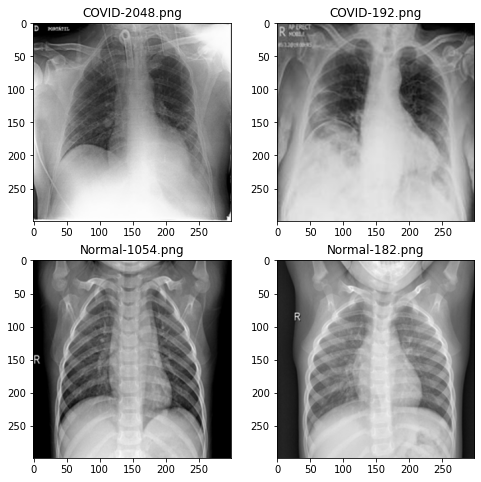

In [ ]:
import os
import shutil
import glob
import numpy as np
from random import randrange

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Model name
pretrained_model_name = 'DenseNet201' 

# Report
FINAL_REPORT_METRICS = []
FINAL_REPORT_METRICS_TITLE = ['Model Name','Info','Accuracy', 'Sensitivity/Recall', 'Specificity', 'PPV', 'NPV','Balanced_accuracy','F1', 'AUC', 'TN', 'FP', 'FN', 'TP']

# Folder del proyecto
project_folder = "/content/drive/MyDrive/UNI/DSc/Ciclo 6/Taller de Machine Learning/Session Final/covid19-rx-project"

files_train_covid19 = glob.glob(project_folder+"/dataset/train/covid19/*.png")
files_test_covid19 = glob.glob(project_folder+"/dataset/test/covid19/*.png")
files_train_normal = glob.glob(project_folder+"/dataset/train/normal/*.png")
files_test_normal = glob.glob(project_folder+"/dataset/test/normal/*.png")

# Obteniendo imágenes al azar de cada folder
file_train_covid19 = files_train_covid19[randrange(len(files_train_covid19))]
image_train_covid19 = image.load_img(file_train_covid19)

file_test_covid19 = files_test_covid19[randrange(len(files_test_covid19))]
image_test_covid19 = image.load_img(file_test_covid19)

file_train_normal = files_train_normal[randrange(len(files_train_normal))]
image_train_normal = image.load_img(file_train_normal)

file_test_normal = files_test_normal[randrange(len(files_test_normal))]
image_test_normal = image.load_img(file_test_normal)

# Visualizando 4 imágenes
fig = plt.gcf()
fig.set_size_inches(8, 8)

plt.subplot(2,2,1)
plt.imshow(image_train_covid19)
plt.title(file_train_covid19.split("/")[-1])

plt.subplot(2,2,2)
plt.imshow(image_test_covid19)
plt.title(file_test_covid19.split("/")[-1])

plt.subplot(2,2,3)
plt.imshow(image_train_normal)
plt.title(file_train_normal.split("/")[-1])

plt.subplot(2,2,4)
plt.imshow(image_test_normal)
plt.title(file_test_normal.split("/")[-1])

plt.show()


 ## **SECCIÓN I - PREPROCESAMIENTO DE DATOS**
---

**Cargar dataset TRAIN y aplicar Data Augmentation:**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dimensión de las imgs a procesar
img_width = 224
img_height = 224
batch_size = 40

# Data Augmentation and Normalization
datagen_train = ImageDataGenerator(rescale=1.0/255.0,      # Normalizar los valores al rango [0-1]
                                   horizontal_flip=True,   # Giro horizontal
                                   rotation_range=15,      # Giro aleatorio (clockwise) entre 0 y 15 grados
                                   width_shift_range=0.15,  # Mover la img horizontelmente 15%
                                   height_shift_range=0.15, # Mover la img verticalmente 15%
                                   zoom_range=0.2)          # Zoom in / Zoom out aleatorio de 20% => 80% - 120%

# Leer imagenes del folder dataset/train
training_set_imgs = datagen_train.flow_from_directory(project_folder+"/dataset/train",
                                                      target_size = (img_width, img_height),
                                                      class_mode = 'binary',
                                                      classes = ['normal','covid19'],
                                                      batch_size = batch_size)
# Mostrando resultados
num_imgs_training = len(training_set_imgs.filenames)

print("\n")
print("Núm. de imgs ENTRENAMIENTO:", num_imgs_training)
print("Classes:", training_set_imgs.class_indices)
print("Núm. Classes [0]:", np.sum(training_set_imgs.labels == 0, axis=0))
print("Núm. Classes [1]:", np.sum(training_set_imgs.labels == 1, axis=0))

Found 2000 images belonging to 2 classes.


Núm. de imgs ENTRENAMIENTO: 2000
Classes: {'normal': 0, 'covid19': 1}
Núm. Classes [0]: 1000
Núm. Classes [1]: 1000


**Mostrando datos resultado de Data augmentation:**

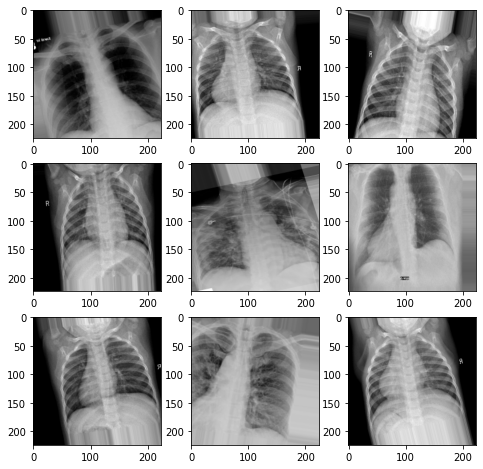

In [ ]:
import copy 

# Visualizando data augmentation para 1 imagen
fig = plt.gcf()
fig.set_size_inches(8, 8)

it = copy.copy(training_set_imgs)

for i in range(9):
	plt.subplot(3,3,1 + i)
	batch = it.next()[0]
	imagenp = (batch[0]*255).astype('uint8')
	plt.imshow(imagenp)
plt.show()

**Cargar dataset TEST sin aplicar Data Augmentation:**

In [ ]:
# Data Normalization
datagen_test = ImageDataGenerator(rescale=1.0/255.0)

# Leer imagenes del folder dataset/train
testing_set_imgs = datagen_test.flow_from_directory(project_folder+"/dataset/test",
                                                      target_size = (img_width, img_height),
                                                      class_mode = 'binary',
                                                      classes = ['normal','covid19'],
                                                      batch_size = batch_size,
                                                      shuffle=False)
# Mostrando resultados
num_imgs_testing = len(testing_set_imgs.filenames)

print("\n")
print("Núm. de imgs TEST:", num_imgs_testing)
print("Classes:", testing_set_imgs.class_indices)
print("Núm. Classes [0]:", np.sum(testing_set_imgs.labels == 0, axis=0))
print("Núm. Classes [1]:", np.sum(testing_set_imgs.labels == 1, axis=0))

Found 400 images belonging to 2 classes.


Núm. de imgs TEST: 400
Classes: {'normal': 0, 'covid19': 1}
Núm. Classes [0]: 200
Núm. Classes [1]: 200


## **SECCIÓN II - CONSTRUYENDO LA RED NEURONAL ARTIFICIAL (CNN) - ARQUITECTURA**
---

**Cargar Modelo pre-entrenado DenseNet:**

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications
from tensorflow.keras.applications.densenet import DenseNet201

# Cargando modelo
pretrained_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

pretrained_model.summary();

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                       

<!-- **Congelar (freeze) los params en el Feature Extractor:** -->

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = False

pretrained_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                       

**Agregando el clasificador propio:**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout

# Definiendo una Red Neuronal vacía
model = Sequential()

# Agregando la parte convolucional (base)
model.add(pretrained_model)               # Modelo base

# Clasificador propio
model.add(GlobalAveragePooling2D())       # GlobalAveragePooling2D https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
model.add(Dense(1000, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

print("Arquitectura final:")
model.summary()

Arquitectura final:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1000)              1921000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 20,243,985
Trainable params: 1,922,001
Non-trainable params: 18,321,984
______________

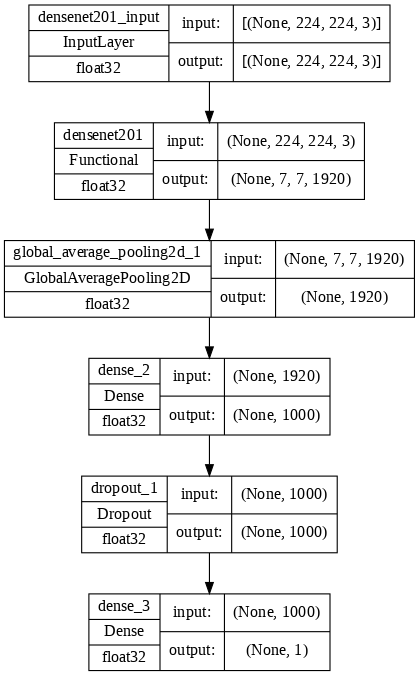

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, rankdir='TB',to_file=project_folder + '/output/' + pretrained_model_name + '_plot.png',dpi=80)

## **SECCIÓN III - ENTRENANDO LA RED NEURONAL ARTIFICIAL (CNN)**
---

**Compilar la Red Neuronal Convolucional:**

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

opt = SGD(learning_rate=0.008, momentum=0.9)
# opt = Adam(lr=0.008, beta_1=0.9, beta_2=0.999)

# COMPILANDO la Red Neuronal Convolucional
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

**Entrenar la Red Neuronal convolucional:**

In [ ]:
%%time

epochs=20

# Entrenar
history = model.fit(training_set_imgs,
                    epochs=epochs,
                    steps_per_epoch=np.ceil(num_imgs_training/batch_size),
                    validation_data=testing_set_imgs,
                    validation_steps=np.ceil(num_imgs_testing/batch_size))

Epoch 1/20
50/50 [==============================] - 46s 717ms/step - loss: 0.3975 - accuracy: 0.8000 - val_loss: 0.3202 - val_accuracy: 0.8600
Epoch 2/20
50/50 [==============================] - 33s 650ms/step - loss: 0.3134 - accuracy: 0.8660 - val_loss: 0.3010 - val_accuracy: 0.8750
Epoch 3/20
50/50 [==============================] - 33s 652ms/step - loss: 0.2966 - accuracy: 0.8725 - val_loss: 0.4981 - val_accuracy: 0.7950
Epoch 4/20
50/50 [==============================] - 33s 665ms/step - loss: 0.2689 - accuracy: 0.8885 - val_loss: 0.2688 - val_accuracy: 0.8900
Epoch 5/20
50/50 [==============================] - 33s 655ms/step - loss: 0.2435 - accuracy: 0.8895 - val_loss: 0.2239 - val_accuracy: 0.9025
Epoch 6/20
50/50 [==============================] - 37s 732ms/step - loss: 0.2344 - accuracy: 0.9020 - val_loss: 0.2512 - val_accuracy: 0.8950
Epoch 7/20
50/50 [==============================] - 33s 665ms/step - loss: 0.2545 - accuracy: 0.8835 - val_loss: 0.3330 - val_accuracy: 0.8575

**Graficar resultados del entrenamiento:**

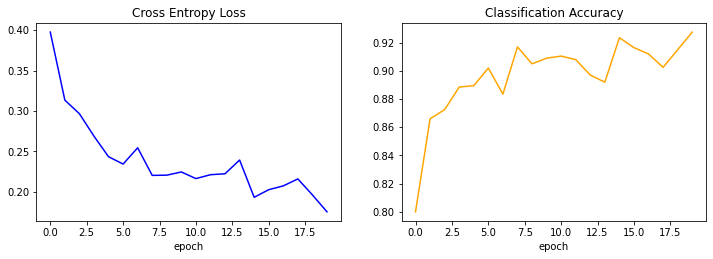

In [ ]:
# GRAFICANDO resultados
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(12, 8)

# plot loss
plt.subplot(2,2,1)
plt.title('Cross Entropy Loss')
plt.xlabel("epoch")
plt.plot(history.history['loss'], color='blue', label='train')

# plot accuracy
plt.subplot(2,2,2)
plt.title('Classification Accuracy')
plt.xlabel("epoch")
plt.plot(history.history['accuracy'], color='orange', label='train')

## **SECCIÓN IV - EVALUACIÓN DE LA RED NEURONAL ARTIFICIAL (CNN)**
---

**Evaluación vía 'evaluate_generator':**

In [ ]:
# Accuraccy del Test (Usar este valor como referencial solamente https://github.com/keras-team/keras/issues/6499)
eval = model.evaluate(testing_set_imgs, steps=np.ceil(num_imgs_testing/batch_size))

print('\nValidación en Test:')
print("Loss: {:.4}".format(eval[0]))
print("Accuracy: {:.2%}".format(eval[1]))

10/10 [==============================] - 2s 197ms/step - loss: 0.2627 - accuracy: 0.8975

Validación en Test:
Loss: 0.2627
Accuracy: 89.75%


**Evaluación vía 'predict' y Matriz de Confusión:**

In [ ]:
# Matriz de Confusión
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

THRESHOLD=0.5
testing_set_imgs.reset() #batch_index=0

Y_pred = model.predict(testing_set_imgs, steps=np.ceil(num_imgs_testing/batch_size))
y_pred = np.where(Y_pred >= THRESHOLD, 1, 0)
# print(Y_pred)
# print(y_pred)

cm = confusion_matrix(testing_set_imgs.classes, y_pred)
print("\nMatriz de Confusión:\n")
print(cm)

# print('\nClassification Report:')
# classes_names = ['normal', 'covid19']
# print(classification_report(testing_set_imgs.classes, y_pred, target_names=classes_names))

10/10 [==============================] - 5s 199ms/step

Matriz de Confusión:

[[190  10]
 [ 31 169]]


**Visualizando la Matriz de Confusión:**

In [ ]:
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de Confusión Normalizada'
        else:
            title = 'Matriz de Confusión sin Normalizar'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión Normalizada")
    else:
        print('Matriz de Confusión sin Normalizar')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(linewidth=.0)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt.show()
    return ax

def getMetrics(cm, model_name, info):
    TN, FP, FN, TP = cm.ravel()
    # Accuracy
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    # Sensitivity/Recall
    sensitivity = TP/(TP+FN)
    # Specificity
    specificity = TN/(TN+FP)
    # Positive Predictive Value (PPV)/ Precision
    PPV = TP/(TP + FP)
    # Negative Predictive Value (NPV)
    NPV = TN/(TN + FN)
    # BalancedAccuracy
    BA = (sensitivity + specificity)/2
    # F1Score
    F1 = 2*((PPV * sensitivity)/(PPV + sensitivity))

    print("Accuracy:           ","({:.2%})".format(accuracy))
    print("Sensitivity/Recall: ","({:.2%})".format(sensitivity))
    print("Specificity:        ","({:.2%})".format(specificity))
    print("PPV:                ","({:.2%})".format(PPV))
    print("NPV:                ","({:.2%})".format(NPV))
    print("Balanced Accuracy:  ","({:.2%})".format(BA))
    print("F1 Score:           ","({:.2%})".format(F1))

    report_metrics = [model_name, info,"%.4f" % accuracy, "%.4f" % sensitivity, "%.4f" % specificity, "%.4f" % PPV, "%.4f" % NPV,"%.4f" % BA,
                      "%.4f" % F1, 'AUC', TN, FP, FN, TP]
    
    return report_metrics

def plot_roc_curve(fpr, tpr, auc_score, model_name):
    plt.figure()
    plt.plot(fpr, tpr, marker='.', label = "".join([model_name, " (area = %0.2f)"]) % auc_score)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

**Métricas de la Matriz de Confusión:**

Matriz de Confusión sin Normalizar


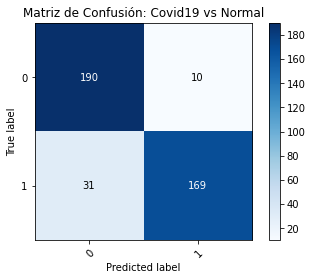

10/10 [==============================] - 2s 203ms/step
AUCROC: 96.89%
Accuracy:            (89.75%)
Sensitivity/Recall:  (84.50%)
Specificity:         (95.00%)
PPV:                 (94.41%)
NPV:                 (85.97%)
Balanced Accuracy:   (89.75%)
F1 Score:            (89.18%)


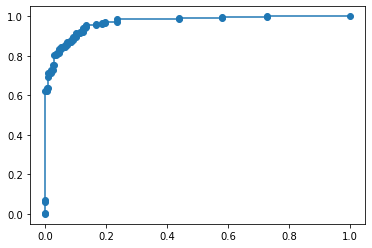

In [ ]:
# Confusion Matrix
plot_confusion_matrix(testing_set_imgs.classes, y_pred, normalize=False,title="Matriz de Confusión: Covid19 vs Normal")

# ROC Curve
Y_pred_proba = model.predict(testing_set_imgs, steps=np.ceil(num_imgs_testing/batch_size))
AUC = roc_auc_score(testing_set_imgs.classes, Y_pred_proba)
print("AUCROC: {:.2%}".format(AUC))

fpr, tpr, thresholds = roc_curve(testing_set_imgs.classes, Y_pred_proba)
plt.plot(fpr,tpr,'-o', label=pretrained_model_name + " (auc=%.4f)"  % (AUC))
# Métricas (https://en.wikipedia.org/wiki/Confusion_matrix)
metrics = getMetrics(cm, pretrained_model_name, "Covid19+")
metrics = [str(AUC) if item == 'AUC' else item for item in metrics]
FINAL_REPORT_METRICS.append(metrics)



In [ ]:
import pandas as pd
final_report = pd.DataFrame(FINAL_REPORT_METRICS, columns=FINAL_REPORT_METRICS_TITLE)
final_report.to_csv("/".join([project_folder, 'output/results', pretrained_model_name + '_results.csv']), index=False) 
final_report

,Model Name,Info,Accuracy,Sensitivity/Recall,Specificity,PPV,NPV,Balanced_accuracy,F1,AUC,TN,FP,FN,TP
0,DenseNet201,Covid19+,0.8975,0.8450,0.9500,0.9441,0.8597,0.8975,0.8918,AUC,190,10,31,169
1,DenseNet201,Covid19+,0.8975,0.8450,0.9500,0.9441,0.8597,0.8975,0.8918,0.96895,190,10,31,169


## **SECCIÓN V - GUARDANDO LA RED NEURONAL ARTIFICIAL EN DISCO**
---

**Guardando modelo en disco:**

In [ ]:
# Guardando Arquitectura y Pesos como archivos diferentes
model_json = model.to_json()
with open(project_folder + "/output/covid19_" + pretrained_model_name + "_config.json","w") as json_file:
  json_file.write(model_json)

model.save_weights(project_folder + "/output/covid19_" + pretrained_model_name + "_weights.h5")
print("Modelo guardado en disco ...")

Modelo guardado en disco ...


In [ ]:
# Cuardando como un único archivo
model.save(project_folder + "/output/covid19_" + pretrained_model_name + "_full.h5")
print("Modelo guardado en disco ...")

Modelo guardado en disco ...


## **SECCIÓN VI - CARGANDO LA RED NEURONAL ARTIFICIAL EN DISCO Y REALIZANDO PREDICCIONES**
---

**Cargando modelo de disco:**

In [ ]:
# Cargando modelo desde el disco
from keras.models import load_model
# load model
loaded_model = load_model(project_folder + "/output/covid19_" + pretrained_model_name + "_full.h5")
# summarize model
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1000)              1921000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 20,243,985
Trainable params: 1,922,001
Non-trainable params: 18,321,984
__________________________________

**Realizando predicciones:**

Image type: <class 'PIL.Image.Image'>
Image size: (224, 224)


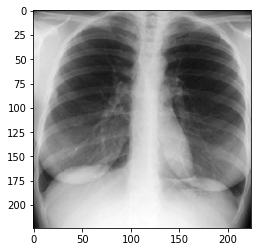

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import urllib.request

# Cargando imagen a predecir: 
# https://radiologyassistant.nl/chest/covid-19-ct-findings-in-25-patients
# URL_image_rx_test = 'https://radiologyassistant.nl/assets/x.jpg'
# http://www.meddean.luc.edu/lumen/meded/medicine/pulmonar/cxr/atlas/cxratlas_f.htm
URL_image_rx_test = 'https://www.meddean.luc.edu/lumen/meded/medicine/pulmonar/cxr/atlas/images/71bl.jpg'

with urllib.request.urlopen(URL_image_rx_test) as url:
   with open('temp.jpg', 'wb') as f:
       f.write(url.read())
image_test = 'temp.jpg'

# load an image in PIL format
image_to_predict = image.load_img(image_test, target_size=(img_width, img_height))
print('Image type:',type(image_to_predict))
print('Image size:',image_to_predict.size)
plt.imshow(image_to_predict)
plt.show()

In [ ]:
# Procesando la imagen
test_image = image.img_to_array(image_to_predict) # Imagen como NumPy array
test_image = np.expand_dims(test_image, axis = 0) # Reshaping de (w,h,c) --> (1,w,h,c)
test_image = test_image.astype('float32')         # Valores de [0-255] --> [0.0-255.0]
test_image /= 255                                 # Valores en [0.0-1.0]

# Prediction
output = loaded_model.predict(test_image)[0][0]
print(output)

1/1 [==============================] - 0s 44ms/step
0.304977


In [ ]:
# Resultados
prediction = 1 if (output >= THRESHOLD) else 0

CLASSES = ['Normal', 'Covid19+']

ClassPred = CLASSES[prediction]
ClassProb = output

print("Pedicción:", ClassPred)
print("Prob: {:.2%}".format(ClassProb))

Pedicción: Normal
Prob: 30.50%
